# Python 2020 class
## Applied python/pandas/numpy/seaborn: RNA-seq

Lecture 14, Lili Blumenberg, May 19th, 2020. 

Notebook and data available at: https://github.com/MarkGrivainis/itp_spring_2020/tree/lecture_14

Environment requirements:
pandas  
numpy  
scipy  
seaborn  
matplotlib  
scikit-learn  

We will be exploring an RNA-seq count table. The experiment is RNA-seq from mouse T-cells that have been challenged different numbers of times with peptides to simulate exhaustion. 

### First lets grab the data and notebooks:
```bash
git add .
git commit -m ‘my changes’
git fetch
git checkout lecture/14
```

Then we can install any missing reqs

In [1]:
%%bash
# conda install -n itp_2020 pandas numpy seaborn scipy matplotlib scikit-learn
# mkdir -p data
## If you want to get the data yourself and you're on a terminal that has wget installed, you can do it this way. 
# wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE150nnn/GSE150120/suppl/GSE150120_str-ReadCount.tab.gz
# gunzip GSE150120_str-ReadCount.tab.gz
# mv GSE150120_str-ReadCount.tab data/GSE150120_str-ReadCount.tab


In [1]:
# Import the standard things we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition, preprocessing
import scipy.stats

# Make the seaborn plots white, make the font arial, and a little bigger. 
sns.set(font = 'arial', style = 'white', font_scale = 1.3)

# Prevent bits of the figures from getting cut off when saving. 
# This is my single favorite line of code. 
import matplotlib
matplotlib.rcParams.update({'savefig.bbox': 'tight'})

# Get some data

This is a data set of raw RNA seq counts from mouse T-cells challenged with   
1. vehicle
2. a single peptide challenge
3. multiple peptide challenges

(3) is supposed to represent an exhausted T cell state, where 1 and 2 are different controls. 

In [2]:
df = pd.read_csv('data/GSE150120_str-ReadCount.tab', sep='\t', index_col=0)

## Check it out a little

In [3]:
df.head()
#Top looks good, but let's make sure it's not all lnRNAs

,m1_multipep_001_nat,m1_nopep_001_nat,m1_onexpep_001_nat,m2_multipep_001_nat,m2_nopep_001_nat,m2_onexpep_001_nat,m3_multipep_001_nat,m3_nopep_001_nat,m3_onexpep_001_nat,m4_multipep_001_nat,m4_nopep_001_nat,m4_onexpep_001_nat,m5_multipep_001_nat
0610005C13Rik,1,0,0,7,0,3,2,1,1,11,0,3,9
0610006L08Rik,0,0,0,0,1,0,0,0,1,1,0,0,0
0610009B22Rik,192,146,121,236,79,122,182,151,103,253,120,92,214
0610009E02Rik,54,77,92,76,60,81,46,137,94,128,146,119,104
0610009L18Rik,64,134,145,69,70,176,86,173,193,95,279,323,133


In [8]:
# By default sample pulls n rows out of the df
df.sample(5)

,m1_multipep_001_nat,m1_nopep_001_nat,m1_onexpep_001_nat,m2_multipep_001_nat,m2_nopep_001_nat,m2_onexpep_001_nat,m3_multipep_001_nat,m3_nopep_001_nat,m3_onexpep_001_nat,m4_multipep_001_nat,m4_nopep_001_nat,m4_onexpep_001_nat,m5_multipep_001_nat
Mir1264,0,0,0,0,0,0,0,0,0,0,0,0,0
Gm23224,0,0,0,0,0,0,0,0,0,0,0,0,0
Gm18462,0,0,0,0,0,0,0,0,0,0,0,0,0
Chgb,1,4,2,6,3,1,1,2,4,0,1,0,4
Gm12324,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Lets see if there are duplicated genes for some reason. 
# Duplicated indexes will cause a lot of problems down the road, so if there are we have to remove them. 
df.index[df.index.duplicated()]
# Woof. Looks like this table has been though excel. 

Index(['1-Mar', '2-Mar'], dtype='object')

In [40]:
# Removing any duplicated rows. Keep in mind there will be other gene names that have been messed up, 
# excel date-ification is not something that can be automatically reversed. 
df = df.loc[df.index.drop_duplicates(keep=False), :]

Looks good to me. 

## Let's make a sample annotation/experimental design table

In [13]:
list(df)

['m1_multipep_001_nat',
 'm1_nopep_001_nat',
 'm1_onexpep_001_nat',
 'm2_multipep_001_nat',
 'm2_nopep_001_nat',
 'm2_onexpep_001_nat',
 'm3_multipep_001_nat',
 'm3_nopep_001_nat',
 'm3_onexpep_001_nat',
 'm4_multipep_001_nat',
 'm4_nopep_001_nat',
 'm4_onexpep_001_nat',
 'm5_multipep_001_nat']

In [9]:
# Do the column names have the info we need?
df.columns

Index(['m1_multipep_001_nat', 'm1_nopep_001_nat', 'm1_onexpep_001_nat',
       'm2_multipep_001_nat', 'm2_nopep_001_nat', 'm2_onexpep_001_nat',
       'm3_multipep_001_nat', 'm3_nopep_001_nat', 'm3_onexpep_001_nat',
       'm4_multipep_001_nat', 'm4_nopep_001_nat', 'm4_onexpep_001_nat',
       'm5_multipep_001_nat'],
      dtype='object')

In [17]:
labels = {'treatment':[ind.split('_')[1] for ind in df.columns]}
labels

{'treatment': ['multipep',
  'nopep',
  'onexpep',
  'multipep',
  'nopep',
  'onexpep',
  'multipep',
  'nopep',
  'onexpep',
  'multipep',
  'nopep',
  'onexpep',
  'multipep']}

In [18]:
exp_design = pd.DataFrame(labels, index=df.columns)
exp_design

,treatment
m1_multipep_001_nat,multipep
m1_nopep_001_nat,nopep
m1_onexpep_001_nat,onexpep
m2_multipep_001_nat,multipep
m2_nopep_001_nat,nopep
m2_onexpep_001_nat,onexpep
m3_multipep_001_nat,multipep
m3_nopep_001_nat,nopep
m3_onexpep_001_nat,onexpep
m4_multipep_001_nat,multipep


In [12]:
exp_design['treatment'].value_counts()

multipep    5
onexpep     4
nopep       4
Name: treatment, dtype: int64

In [103]:
exp_design['exhaustion'] = ['multipep' in ind for ind in exp_design['treatment']]
exp_design.head()

,treatment,exhaustion
m1_multipep_001_nat,multipep,True
m1_nopep_001_nat,nopep,False
m1_onexpep_001_nat,onexpep,False
m2_multipep_001_nat,multipep,True
m2_nopep_001_nat,nopep,False


# Visualize it in some way

In [23]:
df.head()

,m1_multipep_001_nat,m1_nopep_001_nat,m1_onexpep_001_nat,m2_multipep_001_nat,m2_nopep_001_nat,m2_onexpep_001_nat,m3_multipep_001_nat,m3_nopep_001_nat,m3_onexpep_001_nat,m4_multipep_001_nat,m4_nopep_001_nat,m4_onexpep_001_nat,m5_multipep_001_nat
0610005C13Rik,1,0,0,7,0,3,2,1,1,11,0,3,9
0610006L08Rik,0,0,0,0,1,0,0,0,1,1,0,0,0
0610009B22Rik,192,146,121,236,79,122,182,151,103,253,120,92,214
0610009E02Rik,54,77,92,76,60,81,46,137,94,128,146,119,104
0610009L18Rik,64,134,145,69,70,176,86,173,193,95,279,323,133


In [24]:
reads_per_column = df.sum()
reads_per_column
# Looks pretty good

m1_multipep_001_nat    32978485
m1_nopep_001_nat       38127588
m1_onexpep_001_nat     29413396
m2_multipep_001_nat    43236778
m2_nopep_001_nat       24529788
m2_onexpep_001_nat     32453198
m3_multipep_001_nat    39400700
m3_nopep_001_nat       36064651
m3_onexpep_001_nat     30527869
m4_multipep_001_nat    64149089
m4_nopep_001_nat       46291652
m4_onexpep_001_nat     37834891
m5_multipep_001_nat    49207541
dtype: int64

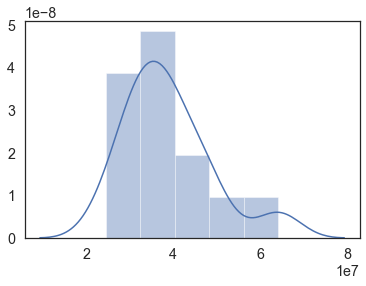

In [26]:
sns.distplot(reads_per_column)

Text(0, 0.5, '# Samples')

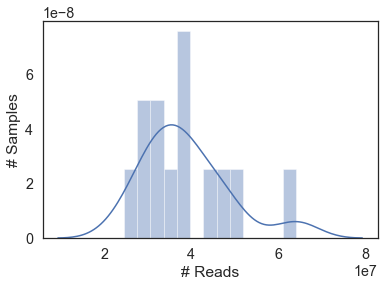

In [27]:
# Did we get an even number of reads per sample?
ax = sns.distplot(reads_per_column, bins=13)
ax.set_xlabel('# Reads')
ax.set_ylabel('# Samples')

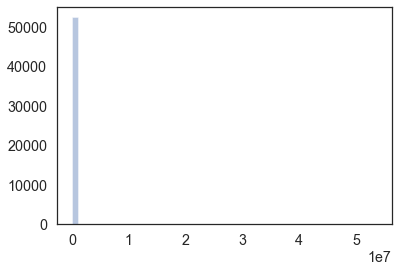

In [29]:
# What is the distribution of reads per gene?
reads_per_gene = df.sum(axis=1)
_ = sns.distplot(reads_per_gene, kde=False)
# Very inflated around 0

In [30]:
df.sum(axis=1).sort_values()
reads_per_gene.sort_values()
# There is also 1 gene that ate up 53e06 reads, more than 10X any other gene. Let's remove it. 
# It's a lincRNA, dunno why this is the case. Good to keep in mind, dig into why this is the case

Gm28993           0
Gm23010           0
Gm23008           0
Gm23007           0
Gm23005           0
             ...   
mt-Co1      2576748
Actb        2734068
Eef1a1      3075130
Rn7sk       5384406
Gm26917    53572034
Length: 52459, dtype: int64

In [33]:
reads_per_gene.max()

53572034

In [37]:
df.sum(axis=1)<53572034

0610005C13Rik    True
0610006L08Rik    True
0610009B22Rik    True
0610009E02Rik    True
0610009L18Rik    True
                 ... 
n-R5s96          True
n-R5s97          True
n-R5s98          True
n-TSaga9         True
n-TStga1         True
Length: 52459, dtype: bool

In [41]:
# We can pull out all indeces that are NOT the one with the highest read count.
everything_but_top_count_gene = df.index.difference([reads_per_gene.idxmax()])
df = df.reindex(everything_but_top_count_gene)

# OR

df.loc[df.sum(axis=1)<53572034, :]

# OR

df.loc[df.sum(axis=1)!=53572034, :]

# OR

df.loc[[i for i in df.index if i is not 'Gm26917']]

# The first one is my favorite because it doesn't require copy/pasting or hard coding which can lead to a mistake. 
# HOWEVER everytime you run that line it will remove the gene with the highest count! 
# The last three options can be run any number of times and will only have an effect the first time. 
# When you are doing analysis in a jupyter notebook, this is important to think about, if you over write variables. 

,m1_multipep_001_nat,m1_nopep_001_nat,m1_onexpep_001_nat,m2_multipep_001_nat,m2_nopep_001_nat,m2_onexpep_001_nat,m3_multipep_001_nat,m3_nopep_001_nat,m3_onexpep_001_nat,m4_multipep_001_nat,m4_nopep_001_nat,m4_onexpep_001_nat,m5_multipep_001_nat
0610005C13Rik,1,0,0,7,0,3,2,1,1,11,0,3,9
0610006L08Rik,0,0,0,0,1,0,0,0,1,1,0,0,0
0610009B22Rik,192,146,121,236,79,122,182,151,103,253,120,92,214
0610009E02Rik,54,77,92,76,60,81,46,137,94,128,146,119,104
0610009L18Rik,64,134,145,69,70,176,86,173,193,95,279,323,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,1,1,1
n-R5s97,0,0,0,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,3,2,3,0,3,2,7,2,5,2,0,4


In [42]:
df.sum()

m1_multipep_001_nat    27756999
m1_nopep_001_nat       33927403
m1_onexpep_001_nat     26167697
m2_multipep_001_nat    40419675
m2_nopep_001_nat       23490284
m2_onexpep_001_nat     29030897
m3_multipep_001_nat    34853741
m3_nopep_001_nat       31392069
m3_onexpep_001_nat     27227680
m4_multipep_001_nat    55638157
m4_nopep_001_nat       41470545
m4_onexpep_001_nat     34479892
m5_multipep_001_nat    44737868
dtype: int64

Text(0, 0.5, '# samples')

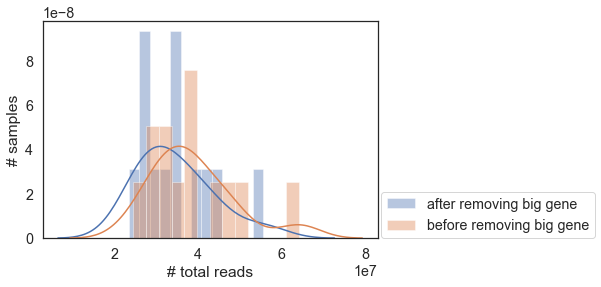

In [43]:
# Let's make sure that one sample didn't just have reads from the over-sampled gene. 
sns.distplot(df.sum(), bins=13, label='after removing big gene')
sns.distplot(reads_per_column, bins=13, label='before removing big gene')
plt.legend(loc=(1.01, 0))
plt.xlabel('# total reads')
plt.ylabel('# samples')
# The distributions look ok, but we want to make sure the top sample didn't become the bottom sample. 

Text(0.5, 0, 'reads before removing big gene')

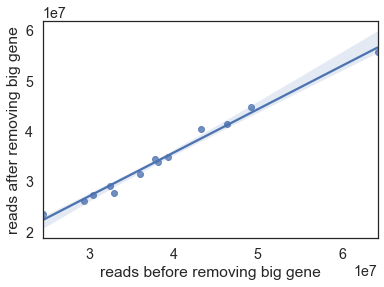

In [44]:
# Is there a big difference for a single sample?
ax = sns.regplot(x=reads_per_column, y=df.sum())
plt.ylabel('reads after removing big gene')
plt.xlabel('reads before removing big gene')

# Filtering low coverage

In [46]:
df.loc[(df.sum(axis=1) > 0), :]

0610005C13Rik     True
0610006L08Rik     True
0610009B22Rik     True
0610009E02Rik     True
0610009L18Rik     True
                 ...  
n-R5s96           True
n-R5s97          False
n-R5s98          False
n-TSaga9          True
n-TStga1          True
Length: 52454, dtype: bool

In [47]:
df.shape

(52454, 13)

In [54]:
# Removing any genes that have 0 across the board
df = df.loc[df.sum(axis=1)>0]
df.shape
print('52454 - 27535 = %s genes had 0 counts' % (52454 - 27535))

52454 - 27535 = 24919 genes had 0 counts


Text(0, 0.5, 'Number of genes')

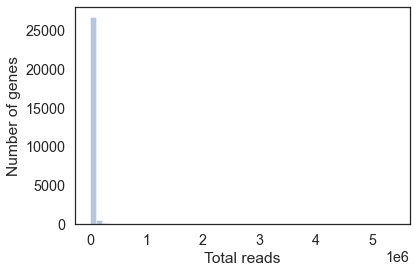

In [55]:
ax = sns.distplot(df.sum(axis=1), kde=False)
ax.set_xlabel('Total reads')
ax.set_ylabel('Number of genes')
# Still highly inflated at the low numbers

Text(0, 0.5, 'Number of genes')

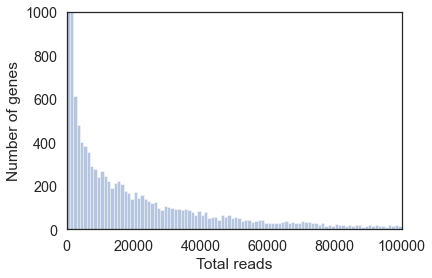

In [58]:
#Lets zoom in
ax = sns.distplot(
    df.sum(axis=1), 
    kde=False, 
    bins=np.arange(0, 100001, 1000)
)
ax.set_xlim(0, 100000)
ax.set_ylim(0, 1000)
ax.set_xlabel('Total reads')
ax.set_ylabel('Number of genes')

Text(0, 0.5, 'Number of genes')

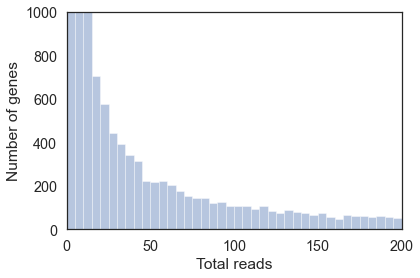

In [59]:
# Lets zoom in even more
sns.distplot(
    df.sum(axis=1), 
    kde=False, 
    bins=np.arange(0, 210, 5)
)
plt.ylim(0, 1000)
plt.xlim(0, 200)
plt.xlabel('Total reads')
plt.ylabel('Number of genes')

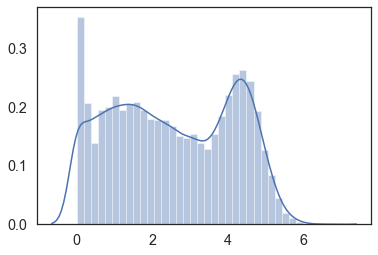

In [63]:
sns.distplot(np.log10(df.sum(axis=1)).replace([np.inf, -np.inf], np.nan))

In [65]:
logged = np.log10(df).replace([np.inf, -np.inf], np.nan)

/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, '# genes')

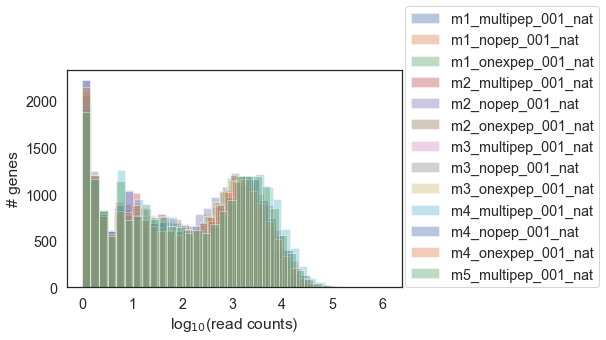

In [69]:
# Let's look at the distribution of reads per gene for all samples. 
for col_name, col in np.log10(df).replace([np.inf, -np.inf], np.nan).iteritems():
    sns.distplot(col, label=col_name, kde=False)
plt.legend(loc=(1.01, 0))
plt.xlabel('log$_{10}$(read counts)')
plt.ylabel('# genes')

Let's remove genes with fewer than 130 reads total (that's an average of ~10 reads per sample)

In [72]:
min_reads = 130
df = df.loc[df.sum(axis=1) > min_reads, :]

df.shape

(15406, 13)

/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, '# genes')

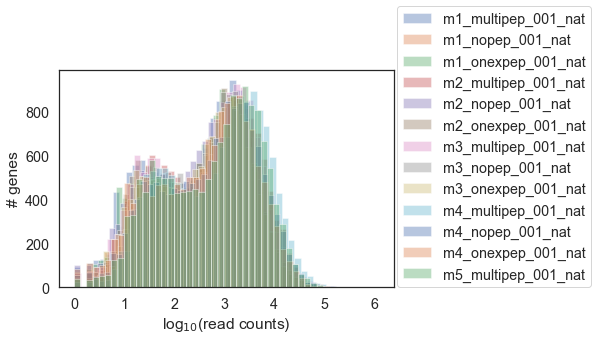

In [73]:
# After setting a lower threshold, let's see reads per gene per sample again. 
logged = np.log10(df).replace([np.inf, -np.inf], np.nan)

for col_name, col in logged.iteritems():
    sns.distplot(col.dropna(), label=col_name, kde=False)
plt.legend(loc=(1.01, 0))
plt.xlabel('log$_{10}$(read counts)')
plt.ylabel('# genes')

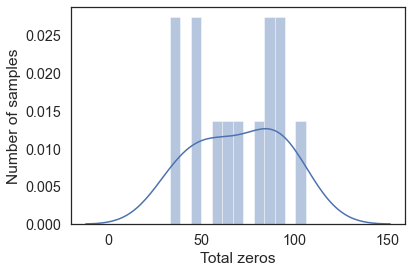

Text(0, 0.5, 'Number of genes')

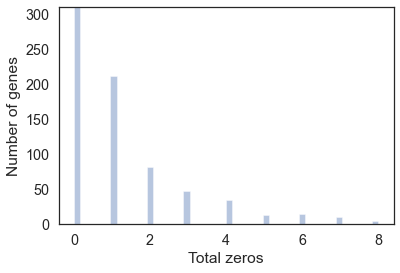

In [77]:
# Let's check for number of 0s per sample and per gene

zeros_per_sample = (df == 0).sum()
zeros_per_gene = (df == 0).sum(axis=1)

sns.distplot(zeros_per_sample, bins=13)
plt.xlabel('Total zeros')
plt.ylabel('Number of samples')
# Ends up as very compared to the number of genes, so we'll let it all go. 
plt.show()
plt.close()


sns.distplot(zeros_per_gene, kde=False)
plt.ylim(0, 310)
plt.xlabel('Total zeros')
plt.ylabel('Number of genes')

In [78]:
df.shape

(15406, 13)

In [79]:
# Let's filter for genes that are non-zero in at least 4 samples

df = df.loc[(df==0).sum(axis=1) < 9]

# OR

df.loc[(df!=0).sum(axis=1) >= 4]

# OR

df.replace(0, np.nan).dropna(thresh=4)

# non-missing values to keep. It is the number of non-missing values required. 
# All of these can be run more than once with no effect. 
# The last one introduces NAs which is bad for machine learning, so let's not use that one right now. 

,m1_multipep_001_nat,m1_nopep_001_nat,m1_onexpep_001_nat,m2_multipep_001_nat,m2_nopep_001_nat,m2_onexpep_001_nat,m3_multipep_001_nat,m3_nopep_001_nat,m3_onexpep_001_nat,m4_multipep_001_nat,m4_nopep_001_nat,m4_onexpep_001_nat,m5_multipep_001_nat
0610009B22Rik,192.0,146.0,121.0,236.0,79.0,122.0,182.0,151.0,103.0,253.0,120.0,92.0,214.0
0610009E02Rik,54.0,77.0,92.0,76.0,60.0,81.0,46.0,137.0,94.0,128.0,146.0,119.0,104.0
0610009L18Rik,64.0,134.0,145.0,69.0,70.0,176.0,86.0,173.0,193.0,95.0,279.0,323.0,133.0
0610009O20Rik,1075.0,979.0,836.0,1198.0,636.0,1055.0,1445.0,1076.0,986.0,2008.0,1614.0,1429.0,1940.0
0610010F05Rik,886.0,819.0,541.0,2377.0,793.0,695.0,1191.0,749.0,569.0,2116.0,1139.0,855.0,1728.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Tp,214.0,408.0,434.0,569.0,473.0,410.0,277.0,586.0,435.0,261.0,428.0,359.0,224.0
mt-Tr,31.0,8.0,5.0,48.0,22.0,24.0,8.0,11.0,14.0,10.0,NaN,NaN,NaN
mt-Tt,21.0,15.0,14.0,26.0,12.0,6.0,8.0,15.0,8.0,21.0,15.0,12.0,10.0
mt-Tw,59.0,58.0,66.0,54.0,48.0,50.0,29.0,81.0,41.0,43.0,55.0,26.0,49.0


In [81]:
df.shape

(15406, 13)

# Normalization and pre-processing

We have to correct for different coverage in different samples.

Let's explore the differences between samples by PCA. I won't go over exactly what PCA is, but vaguely principal components are re-digested features that chew up and combine the features (here, the genes) that explain the most variance of the data set in n-dimensional space. The PCs are ordered by how much of the variance they explain. 

https://setosa.io/ev/principal-component-analysis/

/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, '# genes')

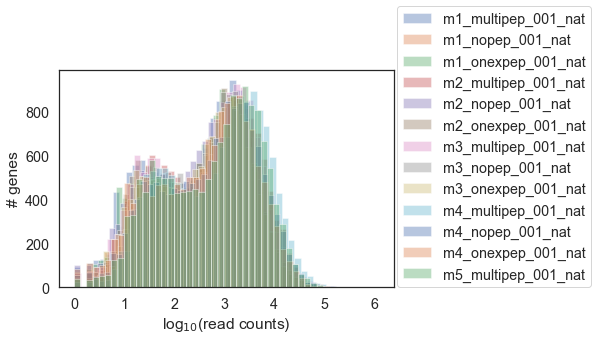

In [82]:
# After setting a lower threshold, let's see reads per gene per sample again. 
logged = np.log10(df).replace([np.inf, -np.inf], np.nan)

for col_name, col in logged.iteritems():
    sns.distplot(col.dropna(), label=col_name, kde=False)
plt.legend(loc=(1.01, 0))
plt.xlabel('log$_{10}$(read counts)')
plt.ylabel('# genes')

In [83]:
pca = decomposition.PCA(n_components=2)

In [86]:
df.transpose()

,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610012G03Rik,0610030E20Rik,0610037L13Rik,0610038B21Rik,0610040B10Rik,...,mt-Tc,mt-Th,mt-Tl2,mt-Tm,mt-Tn,mt-Tp,mt-Tr,mt-Tt,mt-Tw,n-R5s207
m1_multipep_001_nat,192,54,64,1075,886,650,919,539,23,34,...,40,12,28,16,62,214,31,21,59,11
m1_nopep_001_nat,146,77,134,979,819,594,981,917,37,69,...,75,2,18,14,61,408,8,15,58,35
m1_onexpep_001_nat,121,92,145,836,541,475,799,504,30,56,...,49,1,7,13,66,434,5,14,66,10
m2_multipep_001_nat,236,76,69,1198,2377,507,1203,740,21,70,...,473,78,118,30,446,569,48,26,54,9
m2_nopep_001_nat,79,60,70,636,793,218,482,539,50,54,...,484,25,53,17,472,473,22,12,48,18
m2_onexpep_001_nat,122,81,176,1055,695,545,970,563,34,66,...,51,2,12,23,49,410,24,6,50,25
m3_multipep_001_nat,182,46,86,1445,1191,676,1056,781,22,39,...,36,9,28,12,31,277,8,8,29,9
m3_nopep_001_nat,151,137,173,1076,749,559,872,918,48,94,...,96,2,16,42,92,586,11,15,81,25
m3_onexpep_001_nat,103,94,193,986,569,450,1029,559,42,76,...,60,5,8,26,50,435,14,8,41,20
m4_multipep_001_nat,253,128,95,2008,2116,762,1744,1168,56,114,...,43,8,48,18,55,261,10,21,43,21


In [88]:
pca = decomposition.PCA(n_components=2)

In [90]:
pca.explained_variance_ratio_

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [91]:
pca.fit(df.transpose())

PCA(n_components=2)

In [93]:
pca.explained_variance_ratio_

array([0.62037475, 0.20503338])

In [101]:
pca = decomposition.PCA(n_components=2)
pca_transformed_pre_norm = pca.fit_transform(scipy.stats.zscore(df.transpose()))

pca_transformed_pre_norm = pd.DataFrame(pca_transformed_pre_norm, index=df.columns, columns=['PC1', 'PC2'])
pca_transformed_pre_norm

,PC1,PC2
m1_multipep_001_nat,-25.228691,-102.377569
m1_nopep_001_nat,-41.750672,37.186476
m1_onexpep_001_nat,-84.753536,-20.045483
m2_multipep_001_nat,66.039857,-45.595944
m2_nopep_001_nat,-103.286407,0.925740
m2_onexpep_001_nat,-56.188153,-20.880718
m3_multipep_001_nat,24.726234,-93.159929
m3_nopep_001_nat,-50.248017,16.286670
m3_onexpep_001_nat,-61.999765,-1.625703
m4_multipep_001_nat,203.464103,7.203098


In [105]:
pca_transformed_pre_norm = pd.concat([pca_transformed_pre_norm, exp_design], axis=1)

In [107]:
pca.explained_variance_ratio_

array([0.4624692 , 0.26112175])

Text(53.514318513888895, 0.5, 'PC2 - 0.26 explained variance')

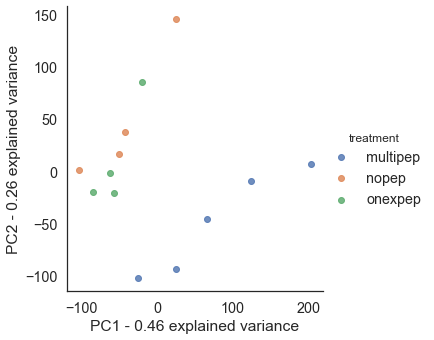

In [108]:
sns.lmplot(x='PC1', y='PC2', data=pca_transformed_pre_norm, hue='treatment', fit_reg=False)

plt.xlabel('PC1 - %.2f explained variance'  % pca.explained_variance_ratio_[0])
plt.ylabel('PC2 - %.2f explained variance'  % pca.explained_variance_ratio_[1])

### Let's decide how to normalize samples

### Sample/column distribution

/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '# genes')

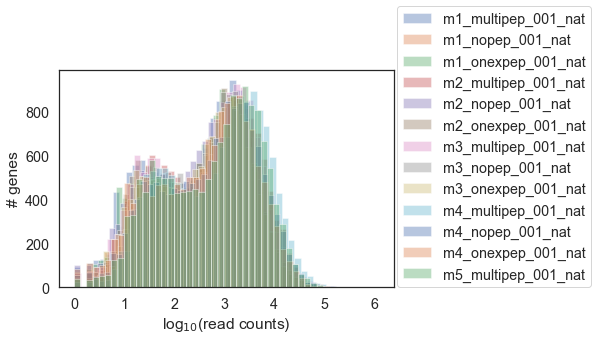

In [35]:
for col_name, col in np.log10(df).replace([np.inf, -np.inf], np.nan).iteritems():
    sns.distplot(col.dropna(), label=col_name, kde=False)
plt.legend(loc=(1.01, 0))
plt.xlabel('log$_{10}$(read counts)')
plt.ylabel('# genes')

In [110]:
def column_normalize(df, method):
    if method == 'count_per_k':
        return df.divide(df.sum())*1000
        
    if method == 'median':
        return df.divide(df.median())
    
    if method == 'median_of_ratios':
        ratios = df.divide(df.mean(axis=1), axis=0)
        return df.divide(ratios.median())
    
    if method == 'quantile':
        temp = preprocessing.quantile_transform(
            df, n_quantiles=len(df), output_distribution='normal', copy=True
        )
        temp = pd.DataFrame(temp, index=df.index, columns=df.columns)
        return temp

### Challenge, logic flow: How would you change this function so that it's performing these methods on the logged version of data, but still returning unlogged data?

### Normalizing for sample coverage

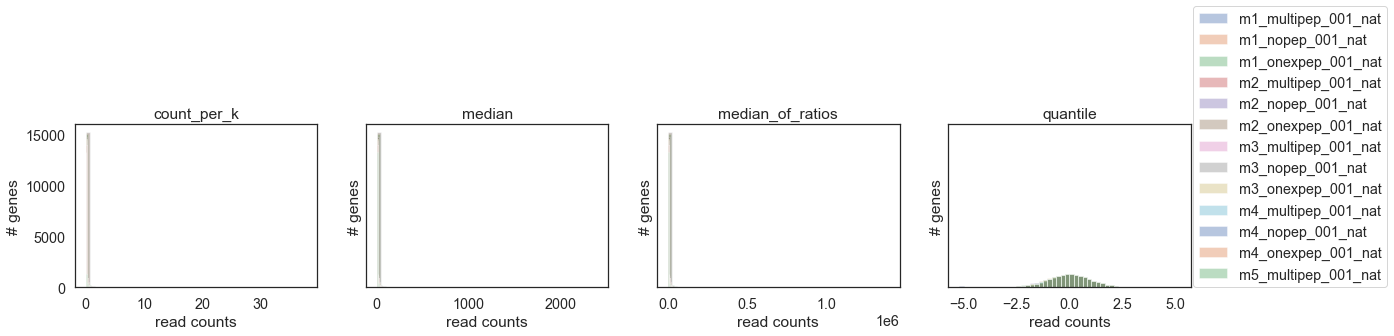

In [111]:
methods = ['count_per_k', 'median', 'median_of_ratios', 'quantile']

fig, axs = plt.subplots(ncols=4, figsize=(20, 3), sharey=True)

for i, method in enumerate(methods):

    ax_to_plot_on = axs[i]
    normed = column_normalize(df, method)
    
    for col_name, col in normed.iteritems():
        sns.distplot(col.dropna(), label=col_name, kde=False, ax=ax_to_plot_on)
    ax_to_plot_on.set_title(method)
    
    ax_to_plot_on.set_xlabel('read counts')
    ax_to_plot_on.set_ylabel('# genes')
# plt.xlim(-2, 2)
plt.legend(loc=(1.01, 0))
plt.show()
plt.close()

### Challenge, visualization: change the code above to add the un-normalized data on the left or right in a 5th plot

/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log2
  app.launch_new_instance()


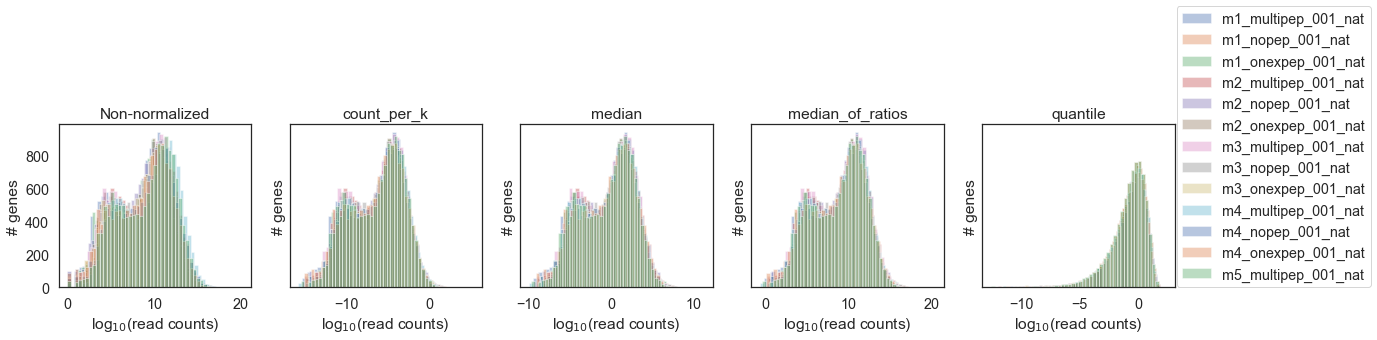

In [112]:
methods = ['count_per_k', 'median', 'median_of_ratios', 'quantile']

fig, axs = plt.subplots(ncols=5, figsize=(20, 3), sharey=True)

ax = axs[0]
for col_name, col in np.log2(df).replace([np.inf, -np.inf], np.nan).iteritems():
    sns.distplot(col.dropna(), label=col_name, kde=False, ax=ax)
ax.set_title('Non-normalized')
ax.set_xlabel('log$_{10}$(read counts)')
ax.set_ylabel('# genes')
    
for i, method in enumerate(methods):
    ax = axs[i+1]
    normed = column_normalize(df, method)
    
    for col_name, col in np.log2(normed).replace([np.inf, -np.inf], np.nan).iteritems():
        sns.distplot(col.dropna(), label=col_name, kde=False, ax=ax)
    ax.set_title(method)
    
    ax.set_xlabel('log$_{10}$(read counts)')
    ax.set_ylabel('# genes')
# plt.xlim(-2, 2)
plt.legend(loc=(1.01, 0))
plt.show()
plt.close()

/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log2
  app.launch_new_instance()
/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log2
  app.launch_new_instance()


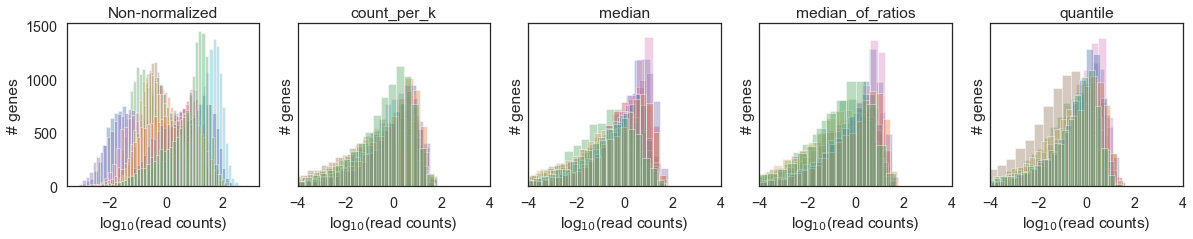

In [113]:
methods = ['count_per_k', 'median', 'median_of_ratios', 'quantile']

fig, axs = plt.subplots(ncols=5, figsize=(20, 3), sharey=True)

ax = axs[0]
for col_name, col in pd.DataFrame(scipy.stats.zscore(np.log2(df).replace([np.inf, -np.inf], np.nan), axis=1, nan_policy='omit')).iteritems():
    sns.distplot(col.dropna(), label=col_name, kde=False, ax=ax)
ax.set_title('Non-normalized')
ax.set_xlabel('log$_{10}$(read counts)')
ax.set_ylabel('# genes')
    
for i, method in enumerate(methods):
    ax = axs[i+1]
    normed = pd.DataFrame(scipy.stats.zscore(column_normalize(df, method), axis=1, nan_policy='omit'))
    
    for col_name, col in np.log2(normed).replace([np.inf, -np.inf], np.nan).iteritems():
        sns.distplot(col.dropna(), kde=False, ax=ax)
    ax.set_title(method)
    
    ax.set_xlabel('log$_{10}$(read counts)')
    ax.set_ylabel('# genes')
    ax.set_xlim(-4, 4)

plt.show()
plt.close()

Let's go forward with z-scored quantile normalization. 

In [115]:
normed = pd.DataFrame(
    scipy.stats.zscore(column_normalize(df, 'quantile'), axis=1, nan_policy='omit'),
    index=df.index,
    columns=df.columns
)

### Let's check the PCA again, see if normalization helped the replicate grouping

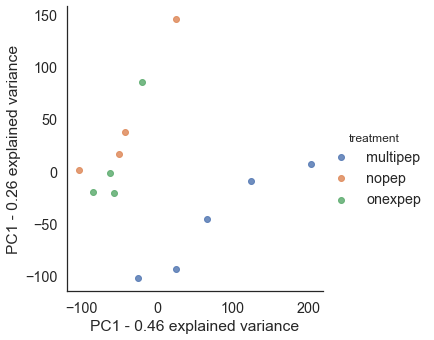

Text(51.15087406944444, 0.5, 'PC1 - 0.17 explained variance')

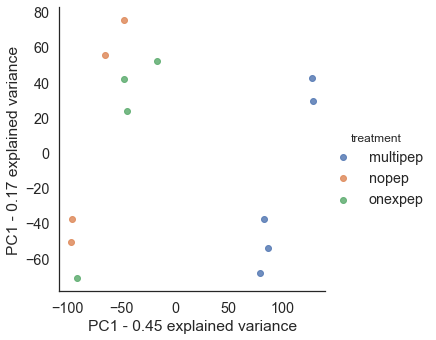

In [117]:
sns.lmplot(x='PC1', y='PC2', data=pca_transformed_pre_norm, hue='treatment', fit_reg=False)
plt.xlabel('PC1 - %.2f explained variance'  % pca.explained_variance_ratio_[0])
plt.ylabel('PC1 - %.2f explained variance'  % pca.explained_variance_ratio_[1])

plt.show()
plt.close()

pca = decomposition.PCA(n_components=2)
pca_transformed = pca.fit_transform(normed.transpose())
pca_transformed = pd.DataFrame(pca_transformed, index=df.columns, columns=['PC1', 'PC2'])
pca_transformed = pd.concat([pca_transformed, exp_design], axis=1)

sns.lmplot(x='PC1', y='PC2', data=pca_transformed, hue='treatment', fit_reg=False)
plt.xlabel('PC1 - %.2f explained variance'  % pca.explained_variance_ratio_[0])
plt.ylabel('PC1 - %.2f explained variance'  % pca.explained_variance_ratio_[1])

## This looks really good! 45% of the variance on PC1 is between the groups we want to compare. The two control groups are co-mingling
### My guess is that PC2 represents batchs, but we would need more meta data to figure that out. 

# Let's run some tests!

We are trying to figure out what is unquie to exhausted T-cells, vs non-stimulated and vs stimulated-once. 
There are different ways to do this, machine learning is definitely one way, but today we are going to just use t-tests. 

In [123]:
# Grab the columns for each group. 
treatment_groups = exp_design.groupby('treatment').groups
treatment_groups

{'multipep': Index(['m1_multipep_001_nat', 'm2_multipep_001_nat', 'm3_multipep_001_nat',
        'm4_multipep_001_nat', 'm5_multipep_001_nat'],
       dtype='object'),
 'nopep': Index(['m1_nopep_001_nat', 'm2_nopep_001_nat', 'm3_nopep_001_nat',
        'm4_nopep_001_nat'],
       dtype='object'),
 'onexpep': Index(['m1_onexpep_001_nat', 'm2_onexpep_001_nat', 'm3_onexpep_001_nat',
        'm4_onexpep_001_nat'],
       dtype='object')}

In [131]:
# If we want all the samples that are in the multipep group, we call these groups with key for the dictionary
treatment_groups['multipep']

Index(['m1_multipep_001_nat', 'm2_multipep_001_nat', 'm3_multipep_001_nat',
       'm4_multipep_001_nat', 'm5_multipep_001_nat'],
      dtype='object')

In [132]:
# Let's run a t-test comparing multi pep and one pep. 
# Because scipy.stats.ttest_ind outputs both a t-statistic and a p-value, we want to save these are two different columns. 
# We can do that by turning it into a series, hence the pd.Series(scipy.stats.ttest_ind()) structure.
# We have to instatiate the df first because otherwise it won't know what vs_onexpep is when we try to add columns to it. 

vs_onexpep = pd.DataFrame()
vs_onexpep[['t-stat', 'pvalue']] = normed.apply(
    lambda row: pd.Series(scipy.stats.ttest_ind(
        row[treatment_groups['multipep']],
        row[treatment_groups['onexpep']]
    )),
    axis=1
)
vs_onexpep.head()

,t-stat,pvalue
0610009B22Rik,2.602816,0.035280
0610009E02Rik,-4.445427,0.002988
0610009L18Rik,-5.929069,0.000582
0610009O20Rik,-0.174631,0.866313
0610010F05Rik,3.587732,0.008884


In [133]:
vs_nopep = pd.DataFrame()
vs_nopep[['t-stat', 'pvalue']] = normed.apply(
    lambda row: pd.Series(scipy.stats.ttest_ind(
        row[treatment_groups['multipep']],
        row[treatment_groups['nopep']]
    )),
    axis=1
)
vs_nopep.head()

,t-stat,pvalue
0610009B22Rik,2.606206,0.035107
0610009E02Rik,-2.241392,0.059955
0610009L18Rik,-2.972230,0.020742
0610009O20Rik,0.845771,0.425643
0610010F05Rik,1.840125,0.108325


### Challenge: rather than repeating the same piece of code twice, how would you turn this into a for loop? 

In [134]:
results = {
    'onexpep': vs_onexpep,
    'nopep': vs_nopep
}

for df in results.values():
    df['FDR'] = (df['pvalue']*len(df)).clip(upper=1.)
    
    df['signedFDR'] = -np.log10(df['FDR']) * (df['t-stat']/df['t-stat'].abs())

Text(0, 0.5, 'no pep signed log FDR')

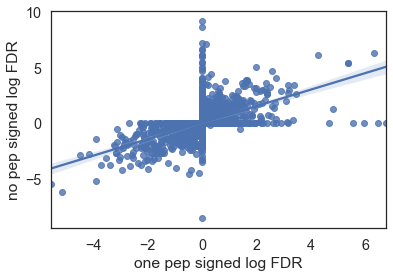

In [136]:
sns.regplot(
    results['onexpep']['signedFDR'],
    results['nopep']['signedFDR']
)
plt.xlabel('one pep signed log FDR')
plt.ylabel('no pep signed log FDR')

### Challenge, indexing and filtering: How would you find the genes that most depleted or enriched in both comparisons?
### Chellenge, numpy: the shape of this is pretty weird, that's probably due to the clipping from the FDR correction. Can you plot signed log p values instead?
### Challenge, visualization: Can you make volacano plots, like DESeq2 spits out? 
### Challenge, visualization, filtering and indexing: How about heatmaps of the most differential genes? Don't try to make a heatmap of all the data or you might crash your computer. 
hint: try https://seaborn.pydata.org/generated/seaborn.clustermap.html or https://seaborn.pydata.org/generated/seaborn.heatmap.html

